# WHERE to GO in ISTANBUL, TURKEY

## 1. Table of Contents

1. Table of Contents  
2. Introduction  
3. Data Collection and APIs  
   3.1. Install and Import Necessary Modules and Libraries  
   3.2. Using Foursquare API  
   3.3. Using Zomato API  
4. Merging and Cleaning Data  
   4.1. Merging Data  
   4.2. Cleaning Data
5. Methodolgy  
6. Analysis  
   6.1. Categories of Venues  
   6.2. Ratings of Venues  
   6.3. Prices of Venues  
7. Clustering
8. Results and Discussion  
9. Conclusion  

## 2. Introduction



***İstanbul*** is a large city and trade capital of Turkey, which is composed of a number of sectors and has a total area of 5.461 square km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

***İstanbul*** is placed at the connection of Europa and Asia. City and continents are divided by the Bosphorus, that is connect the Black Sea to Marmara Sea. It was the capital city of famous empires, such as East Rome and Ottoman. So it has many historical places, and very attractive for tourists.

Whenever a tourist is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Our aim by the project is to cluster venues in ***İstanbul, Turkey*** based on their rating and average prices. 

We will present various venues in the city of ***İstanbul, Turkey***, using ***Foursquare API*** and ***Zomato API***, to help tourists select the restaurants that suit them the best.  

Here, we'll ***identify places that are fit for various individuals*** based on the information we collected from two APIs by using Data Science. 

Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.  


## 3. Data Collection and APIs

To begin with, we will take a look at ***İstanbul on Map*** using the folium library. You will have an idea about the geography of the city. 
Then we will get data from ***two different APIs***.  

 - ***Foursquare API***: We will use the Foursquare API to get venues in İstanbul, in a circle of 6 km radius. 
 - ***Zomato API***: The Zomato API provides data about various venues including the complete address, user ratings and votes, price for two people, price range and many more.

### 3.1. Install and Import Necessary Modules and Libraries

In [1]:
!pip install folium
import folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests

from pandas.io.json import json_normalize
from sklearn.cluster import KMeans


     |████████████████████████████████| 93 kB 4.0 MB/s  eta 0:00:01


In [2]:
# We define the "get_category_type" method to get the category for each venue, obtained from the Foursquare API.

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [3]:
# We define the location where we are.
# As an impovement field, this data can be obtained from GPS data for Mobile Phone users.

Current_Location  = 'İstanbul'
Current_Latitude  = 41.0082
Current_Longitude = 28.9784

print('We are at {}, of where the coordinates are {} and {}.'.format(Current_Location, Current_Latitude, Current_Longitude))


We are at İstanbul, of where the coordinates are 41.0082 and 28.9784.


In [4]:
# Let's see our map of İstanbul, Turkey. The marked place is the Palace of East Rome Empire :)

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)

folium.Marker([Current_Latitude, Current_Longitude]).add_to(location_map)
location_map.save("LocationMap.html")

location_map


### 3.2. Using Foursquare API

We begin by fetching **all venues** in İstanbul upto a range of **6 Km** using the Foursquare API. The Foursquare API has the explore API which allows us to find venues within a given radius from a given coordinates. We will use this API to find all the venues we need.


We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling.

* Foursquare API requires client_id, and client_secret to function, which can be get after creating a developer account.
* We will set the radius as 6 Kilometers.
* The version is a required parameter which defines the date on which we are browsing.

In [5]:
# Let's define the parameters to use the API.

Foursquare_Client_Id     = '2QFOBVAGM03NBKT2O4UKAKZQG1HXC1UKBVZKOJNKCLNPHGY1' 
Foursquare_Client_Secret = '************************************************' #Because of publicly sharing, I starred Secret Code.
Radius                   = 6000        # Finds venues in a radius of 6 km.
Count_Of_Venues          = 100
Version                  = '20201128'   # Current date


In [6]:
# Let's get the venues via API and store the necessary data in a DataFrame, which is named "Foursquare_venues".

pd.set_option('display.max_rows', None)

offset       = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])   

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(Foursquare_Client_Id, 
                                                                                  Foursquare_Client_Secret, 
                                                                                  Version, 
                                                                                  Current_Latitude, 
                                                                                  Current_Longitude, 
                                                                                  Radius,
                                                                                  Count_Of_Venues,
                                                                                  offset)
    result = requests.get(url).json()
    venues_found = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_found

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    
    # Get necessary info from the JSON File
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]
    
    # Find the category of the venue found
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_found < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)

print("Total {} venues found within a radius of {} Km".format(total_venues, Radius/1000))

foursquare_venues.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 217 venues found within a radius of 6.0 Km


,name,categories,lat,lng
0,Ayasofya,Historic Site,41.008435,28.979970
1,Sultan Ahmet Camii,Mosque,41.006407,28.977275
2,Ayasofya Meydanı,Pedestrian Plaza,41.007435,28.979187
3,Yerebatan Sarnıcı,Historic Site,41.008426,28.977942
4,Sultanahmet Meydanı,Plaza,41.006627,28.976105


### 3.3. Using Zomato API

The Zomato API allows to search for any given venue based on certain search filters such as query, latitude, longitude and more, by its **Search Function**. The function returns data only for **open venues** at the moment.

Zomato also requires a ***Zomato user key*** which can be got by having a developer account. 

We will use "name, latitude and longitude" values of venues obtained using Foursquare API to use the **Search Funcion** and get more data for each venue.

 - The **"query"** will be the name of the venue.
 - The **"start"** defines from what offset we want to start, so it wil be 0.
 - The **"count"** defines the number of venues we want to get. Because of having the exact location coordinates, we will fetch only one.
 - We will use the **latitude and longitude** values.
 - We will set the **sorting criteria as real_distance** so each time we will get the venue based on their coordinates.

In [8]:
# Firstly, let's define user-key needed to use the API.
headers = {'user-key': '********************************'}   #Because of publicly sharing, I starred user-key.
venues_data = []

# Next, we get data for venues via API. We store the data in a DataFrame, named "zomato_venues"
for index, row in foursquare_venues.iterrows():

    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])

    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There is an error!")

    try:
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['votes'])
            venues_data.append(venue)
        else:
            venues_data.append(np.zeros(8))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_data, 
                                  columns = ['venue', 'address', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating','votes'])

print("Total {} venues found on Zomato.".format(zomato_venues.shape[0]))

zomato_venues.head()


There is an error!
Total 216 venues found on Zomato.


,venue,address,latitude,longitude,price_for_two,price_range,rating,votes
0,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075061865,28.9797214419,100.0,3.0,2.6,8.0
1,Sultan Cafe Restaurant,"Sultanahmet Mahallesi, At Meydanı Caddesi, No ...",41.0068169910,28.9766536653,150.0,4.0,3.0,14.0
2,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075061865,28.9797214419,100.0,3.0,2.6,8.0
3,House of Medusa,"Alemdar Mahallesi, Yerebatan Caddesi, No 9, Fa...",41.0087575486,28.9773594216,250.0,4.0,4.0,51.0
4,Sultan Cafe Restaurant,"Sultanahmet Mahallesi, At Meydanı Caddesi, No ...",41.0068169910,28.9766536653,150.0,4.0,3.0,14.0


## 4. Merging and Cleaning Data

Data from multiple resources are not always aligned. So, it is important to merge the data retrieved from multiple resources properly.

To do this:
- **Firstly**, we will **plot** the two data on map. 
- **Then**, we will try to **merge data** using their latitude and longitude values. 
  * The **key point** is that: The coordinates are very close or the same for the same venue. 

**Finally**: For the remaining venues, we will inspect the data for ensuring that any remaining **mismatched or noisy data** are also removed. 

After performing the data cleaning actions, the final dataset will be ready for clustering analysis.


In [9]:
# Let's start with plotting the Foursquare data on the map.

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,                  # radius of marker
        popup = label,               # text shown when pressed
        color = 'blue',              # color of marker  
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(location_map)  

location_map.save("Venues_by_Foursquare.html")
location_map


**From the map**, we can infer that there are **clusters** of venues **around Fatih, Beyoğlu, Kadıköy and Şişli**.


In [10]:
# Next, let's see the venues obtained from Zomato on the map.

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    zomato_longitude = float(longitude)
    zomato_latitude = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [zomato_latitude, zomato_longitude],
        radius = 5,                  # radius of marker
        popup = label,               # text shown when pressed
        color = 'red',               # clor of marker  
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(location_map)  

location_map.save("Venues_by_Zomato.html")
locatiohttps://eu-gb.dataplatform.cloud.ibm.com/data/jupyter2/runtimeenv2/v1/wdpx/service/notebook/9750cb4e67c9480eb0b81f16192dad76/dsxjpy/Gzt4e1sN_wjoEMvDy6QQAw:0VFz5tKQpJRuONN6uicpnvUJRVea44QYgAMpXVo0WfvQNu_AG5_oW1GDjJUZRTd2r2_cbH8/container/notebooks/b54255c8-d436-48a1-918d-29a3474bb5d1?api=v2&project=67bac3b9-1375-421d-934c-b32ed75ed638#n_map


**From the map**, we can see the **layout is almost the same** as the Foursquare data.


### 4.1. Merging Data

In [12]:
# Decrease the significancy of coordinates to 4 digits
foursquare_venues['lat']   = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng']   = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude']  = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

# Merge Foursquare and Zomato Venues
merged_venues = pd.concat([foursquare_venues, zomato_venues], axis = 1)


In [13]:
# Calculate the distance between Foursquare and Zomato coordinates for Venues.
merged_venues['lat_diff'] = merged_venues['latitude']  - merged_venues['lat']
merged_venues['lng_diff'] = merged_venues['longitude'] - merged_venues['lng']

# Omit the venues of which the distance difference is higher than 0.0004 (coordinate distance), 
# because most probably they are different venues.

selected_venues = merged_venues[(abs(merged_venues['lat_diff']) <= 0.0004) 
                                & (abs(merged_venues['lng_diff']) <= 0.0004)].reset_index(drop = True)

selected_venues.head()


,name,categories,lat,lng,venue,address,latitude,longitude,price_for_two,price_range,rating,votes,lat_diff,lng_diff
0,Four Seasons Hotel Istanbul at Sultanahmet,Hotel,41.0064,28.9801,Seasons Restaurant - Four Seasons Hotel Sultan...,"Four Seasons Hotel, Cankurtaran Mahallesi, Tev...",41.0064,28.9800,450.0,4.0,4.3,125.0,0.0000,-0.0001
1,Topkapı Sarayı Bab-ı Hümayun Kapısı,Historic Site,41.0085,28.9813,Topkapı Cafe,"Cankurtaran Mahallesi, Soğukçeşme Sokak, No: 2...",41.0087,28.9813,110.0,3.0,0,0.0,0.0002,0.0000
2,Ayasofya Müzesi Padişah Türbeleri,Shrine,41.0079,28.9795,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075,28.9797,100.0,3.0,2.6,8.0,-0.0004,0.0002
3,Old Ottoman Cafe & Restaurant,Turkish Restaurant,41.0107,28.9753,Old Ottoman Cafe & Restaurant,"Alemdar Mahallesi, Prof. Doktor Kazım İsmail G...",41.0107,28.9753,200.0,4.0,4.1,52.0,0.0000,0.0000
4,Sultanahmet,Neighborhood,41.0045,28.9764,Coffee Corner,"Küçükayasofya Mahallesi, Küçükayasofya Caddesi...",41.0041,28.9763,35.0,2.0,0,0.0,-0.0004,-0.0001


When we inspect the data gathered from both APIs, names of some venues are completely different. This may be resulted from 3 things:  
1- There are venues that have specific restaurants/cafes inside them as provided by Zomato API.  
2- Some have been replaced with new restaurants.  
3- Two locations are so close by that they have practically same latitude and longitude values.  

The venues belong to 1&2 are OK for our analysis, but the venues of 3rd group should be removed. We do this **by removing the name** of the venues got **from FourSquare** API.


In [14]:
selected_venues = selected_venues.drop([0]).reset_index(drop = True)

The price data obtained form Zomato API is a **price for two people**. In our study, we will work with **price per person**. So, we use the price data simply dividing by 2:)

After this, we **omit unnecessary or dublicate data** (i.e; dropping columns of DataFrame) from our dataset.


In [15]:
selected_venues['average_price'] = selected_venues['price_for_two']/2           # Price obtained from Zomato is for 2 people.
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])   # finalize the columns.

selected_venues.head()

,categories,venue,address,latitude,longitude,price_range,rating,votes,average_price
0,Historic Site,Topkapı Cafe,"Cankurtaran Mahallesi, Soğukçeşme Sokak, No: 2...",41.0087,28.9813,3.0,0,0.0,55.0
1,Shrine,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075,28.9797,3.0,2.6,8.0,50.0
2,Turkish Restaurant,Old Ottoman Cafe & Restaurant,"Alemdar Mahallesi, Prof. Doktor Kazım İsmail G...",41.0107,28.9753,4.0,4.1,52.0,100.0
3,Neighborhood,Coffee Corner,"Küçükayasofya Mahallesi, Küçükayasofya Caddesi...",41.0041,28.9763,2.0,0,0.0,17.5
4,Gift Shop,Konyalı Restaurant,"Topkapı Sarayı, Cankurtaran Mahallesi, Fatih, ...",41.0107,28.9825,4.0,3.2,64.0,150.0


### 4.2. Cleaning Data

We have rating data obtained from FourSquare API. This is very valuable data for a person who do not have any info or insight abot the venue. So, we examine the Rating Data and see two cleaning need:

1- There are some venues with **no-rating**. So, we should remove these venues.

2- Some venues has a rating, but **number of people who rated is low**. So, it is hard to be sure the rating value really represents the venue or not (Maybe the mans of the venue rated :)). So, we should remove the venues with vote number below a certain number.


In [16]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]   # Omit the venues with 0.0 Rating.
selected_venues = selected_venues[selected_venues['votes'] >= 5.0]    # Omit the venues with Votes below 5 (Not enough concensus for rating)

print("Total venues to be processed: {}".format(selected_venues.shape[0]))
selected_venues.head()


Total venues to be processed: 66


,categories,venue,address,latitude,longitude,price_range,rating,votes,average_price
1,Shrine,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075,28.9797,3.0,2.6,8.0,50.0
2,Turkish Restaurant,Old Ottoman Cafe & Restaurant,"Alemdar Mahallesi, Prof. Doktor Kazım İsmail G...",41.0107,28.9753,4.0,4.1,52.0,100.0
4,Gift Shop,Konyalı Restaurant,"Topkapı Sarayı, Cankurtaran Mahallesi, Fatih, ...",41.0107,28.9825,4.0,3.2,64.0,150.0
5,Restaurant,Mivan Restaurant & Cafe,"Emin Sinan Mahallesi, Piyerloti Caddesi, No 34...",41.0062,28.9691,3.0,3.7,9.0,55.0
6,Bakery,Day Day Pastanesi,"Molla Fenari Mahallesi, İskender Boğazı Sokak,...",41.0096,28.9681,2.0,4.3,76.0,15.0


Now, our Cleaning studies finished and our dataset is ready for analysis.

## 5. Methodology 

**Our goal** is identifying and classifying the **venues in İstanbul*** based on their rating and average prices. This would enable visitors to **find venues easily based on their rating and price preferences.**

***Up to now, we:***
- ***Obtained*** venue data using two different APIs (***Foursquare and Zomato***). 
- ***Explored*** them on a map. 
- ***Examined*** them for merging and cleaning.
- ***Created*** the final dataset for analysis, containing rating and price values for each venue.

Our ***next step*** is to analyse our data. For this we will perform below tasks:
- ***Exploring*** the categories of venues using charts. 
- ***Exploring*** the count of venues with ratings and prices using charts. 
- ***Exploring*** the venues with high/low ratings and highlow prices on a map. 

***Next:***  
As the ***heart of the study**, we will apply the k-Mean Clustering for ***grouping the venues*** based on their price and rating values. This will enable us to identify which venue(s) can be recommended for which type of visitors.

***Finally:***  
We will ***discuss*** the results and ***conclude*** the overall study.

## 6. Analysis

As we mentioned before, the final dataset is ready for analysis.

We will ***explore venues based on their***:
- ***Categories***: Category information obtained from FourSquare gives us insights about venues and location.
- ***Rating***: The rating of a venue are based on user reviews and belongs to a range from 1 to 5. 
- ***Price Range and Price per Person***: The price info gives us insights about venues and location.

### 6.1. Categories of Venues

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list using a chart.

<BarContainer object of 40 artists>

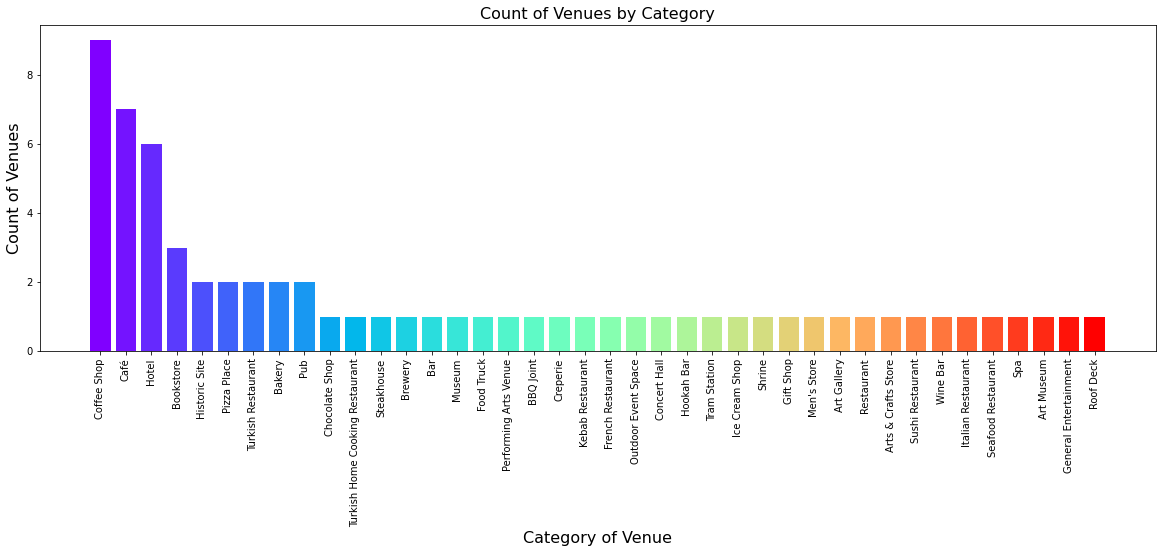

In [17]:
venue_distribution = selected_venues['categories'].value_counts()

colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 6))
plt.xticks(rotation = 90)
plt.xlabel("Category of Venue", fontsize = 16)
plt.ylabel("Count of Venues", fontsize = 16)
plt.title("Count of Venues by Category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)


As seen on the chart, the majority venues are ***Coffee Shop***, ***Cafe*** and ***Hotel***. It seems that tourists are in this area of İstanbul for accomodation and resting.

### 6.2. Ratings of Venues

Rating of a venue is an important factor on which a visitor decides to visit the venue or not. 

To analyse the rating data, we will:
- See what is the ***count of venues for each rating*** on a chart.
- ***Plot*** the venues ***with a color*** code them based on their ratings ***on a map***.


<BarContainer object of 18 artists>

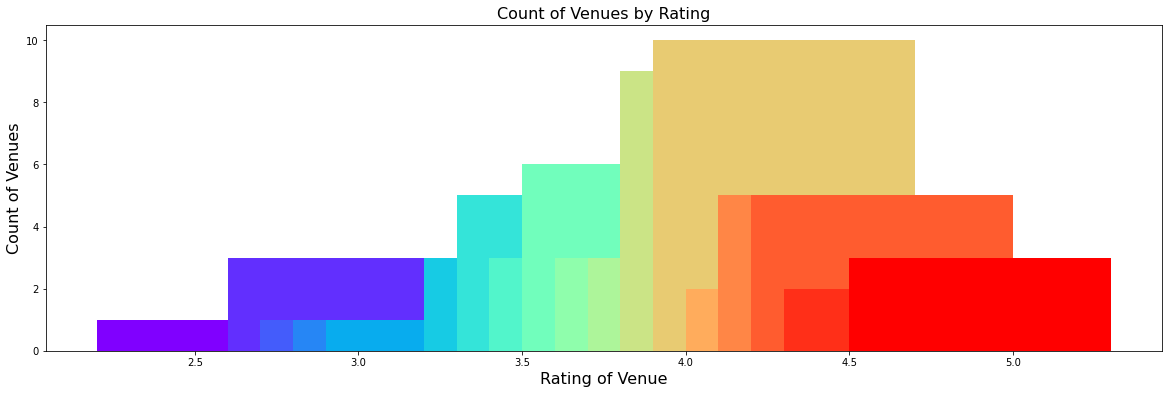

In [18]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()

plt.figure(figsize = (20, 6))
plt.xlabel("Rating of Venue", fontsize = 16)
plt.ylabel("Count of Venues", fontsize = 16)
plt.title("Count of Venues by Rating", fontsize = 16)
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))


As seen on the plot above, majority venues have their rating between 4.0-4.5 interval.

Let's create rating groups for various ratings and plot them in different colors on a map. The ratings will be divided into 4 groups:
 - 1st Group: Up to 2.0
 - 2nd Group: Between 2.1 and 3.0
 - 3rd Group: Between 3.1 and 4.0
 - 4th Group: Greater 4.0

In [19]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Poor', 'OK', 'Good', 'Excellent']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)
selected_venues.head()


,categories,venue,address,latitude,longitude,price_range,rating,votes,average_price,rating_bin
1,Shrine,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075,28.9797,3.0,2.6,8.0,50.0,OK
2,Turkish Restaurant,Old Ottoman Cafe & Restaurant,"Alemdar Mahallesi, Prof. Doktor Kazım İsmail G...",41.0107,28.9753,4.0,4.1,52.0,100.0,Excellent
4,Gift Shop,Konyalı Restaurant,"Topkapı Sarayı, Cankurtaran Mahallesi, Fatih, ...",41.0107,28.9825,4.0,3.2,64.0,150.0,Good
5,Restaurant,Mivan Restaurant & Cafe,"Emin Sinan Mahallesi, Piyerloti Caddesi, No 34...",41.0062,28.9691,3.0,3.7,9.0,55.0,Good
6,Bakery,Day Day Pastanesi,"Molla Fenari Mahallesi, İskender Boğazı Sokak,...",41.0096,28.9681,2.0,4.3,76.0,15.0,Excellent


In [20]:
# Venues on map, colored oaccording to Ratings they have (Rating Groups)

color_map = {'Poor': 'red', 'OK': 'orange', 'Good': 'green', 'Excellent': 'blue'}

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)

for name, address, latitude, longitude, rating_bin, votes in zip(selected_venues['venue'], 
                                                                 selected_venues['address'], 
                                                                 selected_venues['latitude'], 
                                                                 selected_venues['longitude'], 
                                                                 selected_venues['rating_bin'],
                                                                 selected_venues['votes']):

    label = 'Name: {}, Address: {}, Rating_Group: {}, Votes: {}'.format(name, address, rating_bin,votes )
    label = folium.Popup(label, html_parse=True)

    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(location_map)  

location_map.save("Venue_Ratings.html")
location_map


As seen on the map, we cannot say there is a correlation between the location and rating. 

### 6.3. Prices of Venues

We will now take a look the venues based on the price values. We have two price features; one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

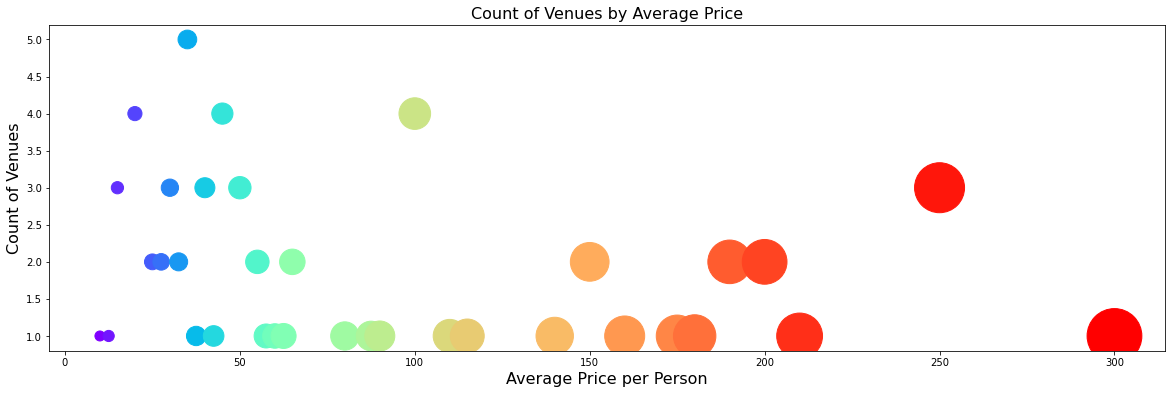

In [21]:
average_prices = selected_venues['average_price'].value_counts().sort_index()

plt.figure(figsize = (20, 6))
plt.xlabel("Average Price per Person", fontsize = 16)
plt.ylabel("Count of Venues", fontsize = 16)
plt.title("Count of Venues by Average Price", fontsize = 16)
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))


From the plot above we can see that a large number of venues have an average price below 75 TL.

We will use the price_range info to plot the venues on a map and represent the venues with lower price in green and move towards red as the price increases.

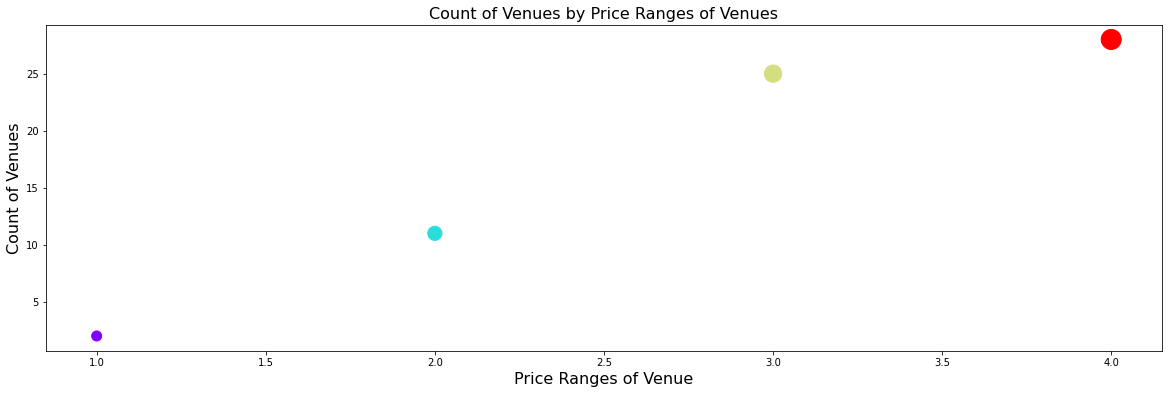

In [22]:
price_ranges = selected_venues['price_range'].value_counts().sort_index()

plt.figure(figsize = (20, 6))
plt.xlabel("Price Ranges of Venue", fontsize = 16)
plt.ylabel("Count of Venues", fontsize = 16)
plt.title("Count of Venues by Price Ranges of Venues", fontsize = 16)
plt.scatter(price_ranges.index, 
            price_ranges.values, 
            s = price_ranges.index*100, 
            c = cm.rainbow(np.linspace(0, 1, len(price_ranges.index))))


As seen on the plot above, a large number of venues have an Price Range 3.0 and more. 

In [23]:
# Venues on map, colored oaccording to Price Ranges they have.

color_map = {'1.0': 'blue', '2.0': 'green', '3.0': 'orange', '4.0': 'red'}

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)

for name, address, latitude, longitude, price_range, average_price in zip(selected_venues['venue'], 
                                                                          selected_venues['address'], 
                                                                          selected_venues['latitude'], 
                                                                          selected_venues['longitude'], 
                                                                          selected_venues['price_range'].astype(str),
                                                                          selected_venues['average_price'].astype(str)):
    
    label = 'Name: {}, Address: {}, Price_Range: {}, Average_Price: {} TL,'.format(name, address, price_range, average_price)
    label = folium.Popup(label, parse_html = True)
    
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(location_map) 

location_map.save("Venue_Price_Ranges.html")
location_map


As seen on the map, we can say there is a correlation between the location and price index. 

## 7. Clustering

We will now cluster all these venues based on their price range and location to identify similar venues and the relationship amongst them. We will cluster the venues into three separate groups.

In [24]:
No_Of_Clusters = 3

# Below line must be openned after the first run of the cell, becouse it deletes the clustering column which created by Clustering tran.
#selected_venues = selected_venues.drop(['cluster_labels'],1) 

#Cluster venues according to their coordinates, Price Ranges and Ratings.
clustering = selected_venues.drop(['venue', 'address', 'votes', 'average_price', 'rating_bin', 'categories'],1)

#Let's run the model ve CLUSTER :)
kMeans = KMeans(n_clusters = No_Of_Clusters, random_state = 0).fit(clustering)

#Assign the Cluster Numbers to the venues, creating a new column.
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head()


,cluster_labels,categories,venue,address,latitude,longitude,price_range,rating,votes,average_price,rating_bin
1,1,Shrine,Sebil Cafe & Restaurant,"Binbirdirek Mahallesi, Ayasofya Meydanı, No 5,...",41.0075,28.9797,3.0,2.6,8.0,50.0,OK
2,0,Turkish Restaurant,Old Ottoman Cafe & Restaurant,"Alemdar Mahallesi, Prof. Doktor Kazım İsmail G...",41.0107,28.9753,4.0,4.1,52.0,100.0,Excellent
4,0,Gift Shop,Konyalı Restaurant,"Topkapı Sarayı, Cankurtaran Mahallesi, Fatih, ...",41.0107,28.9825,4.0,3.2,64.0,150.0,Good
5,1,Restaurant,Mivan Restaurant & Cafe,"Emin Sinan Mahallesi, Piyerloti Caddesi, No 34...",41.0062,28.9691,3.0,3.7,9.0,55.0,Good
6,2,Bakery,Day Day Pastanesi,"Molla Fenari Mahallesi, İskender Boğazı Sokak,...",41.0096,28.9681,2.0,4.3,76.0,15.0,Excellent


In [25]:
# Let's look at the results :)

Cluster_Id = 1
result     = selected_venues[selected_venues['cluster_labels'] == Cluster_Id-1]
cluster_information = pd.DataFrame(data={'Cluster_Id' : [Cluster_Id], 
                                         'Price-TL'   : [result['average_price'].mean()], 
                                         'Price_Range': [result['price_range'].mean()],                                          
                                         'Rating'     : [result['rating'].astype(float).mean()]})

Cluster_Id = 2
result     = selected_venues[selected_venues['cluster_labels'] == Cluster_Id-1]
cluster_information = cluster_information.append(pd.DataFrame(data={'Cluster_Id' : [Cluster_Id], 
                                                                    'Price-TL'   : [result['average_price'].mean()], 
                                                                    'Price_Range': [result['price_range'].mean()],                                          
                                                                    'Rating'     : [result['rating'].astype(float).mean()]}))

Cluster_Id = 3
result     = selected_venues[selected_venues['cluster_labels'] == Cluster_Id-1]
cluster_information = cluster_information.append(pd.DataFrame(data={'Cluster_Id' : [Cluster_Id], 
                                                                    'Price-TL'   : [result['average_price'].mean()], 
                                                                    'Price_Range': [result['price_range'].mean()],                                          
                                                                    'Rating'     : [result['rating'].astype(float).mean()]}))


cluster_information.head().reset_index(drop = True)
                                                 

,Cluster_Id,Price-TL,Price_Range,Rating
0,1,147.500000,4.000000,4.089286
1,2,41.100000,3.000000,4.084000
2,3,19.423077,1.846154,4.015385


According to the clustering results, it seems that the main independent parameter to identify the cluster is Price Range of the venue.

For advertisal purposes, we can name the clusters like below {In real-life, this will be a business issue}:
- Cluster-1: **Gourmet**  - Expensive  & Excellent
- Cluster-2: **Worth_It** - Good Price & Good Rating
- Cluster-3: **Up_To_You**- Low Price  & Rating OK

In [26]:
# Let's see the results on map.

location_map = folium.Map(location = [Current_Latitude, Current_Longitude], zoom_start = 12)
color_map = { 0: 'green', 1: 'red', 2: 'blue', 3: 'orange'}
markers_colors = []

# adding venues to map
for venue, cluster, latitude, longitude, price_range, average_price, rating, votes in zip(selected_venues['venue'], 
                                                                                          selected_venues['cluster_labels'], 
                                                                                          selected_venues['latitude'], 
                                                                                          selected_venues['longitude'],
                                                                                          selected_venues['price_range'], 
                                                                                          selected_venues['average_price'], 
                                                                                          selected_venues['rating'], 
                                                                                          selected_venues['votes']):

    label = 'Name: {}, Cluster: {}, Price_Range: {}, Average_Price: {} TL,Rating: {}, # of Votes: {}'.format(name, 
                                                                                                             cluster, 
                                                                                                             price_range,
                                                                                                             average_price, 
                                                                                                             rating, votes)
    label = folium.Popup(label, parse_html = True)

    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(location_map)

    
# adding cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]

    label = 'Cluster #: {}'.format(index+1)
    label = folium.Popup(label, parse_html = True)

    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.0).add_to(location_map)

location_map.save("Venues_and_Clusters.html")
location_map

As we mentioned before, it seems that there a significant correlation between Price Index and Location of venues. 

We see the same figure on the map. Cluster-1&2 are located separately. Cluester-3 is everywhere :)


## 8. Results and Discussion 

Based on our analysis above, we can make some conclusions that will be useful to help visitors of İstanbul, Turkey.

After collecting data from the Foursquare and Zomato APIs, we got a list of 216 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the noisy data. This resulted in a total venue count of 66.

We identified that from the total set of venues, majority of them were Cafes,Coffee Shop and Hotels. It seems that tourists are in this area of İstanbul for accomodation and resting.

While the complete range of ratings range from 1 to 5, the majority venues have ratings between 4.0-4.5. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we see there is not a significant correlation beween the location and rating of the venues.

When we take a look at the price values of each venue, we explore that many venues have prices which are below 75 TL for one person. On plotting the venues based on their price range on the map, we discovered that location of venues has a signicant correlation with the price range of venues.

Finally, through clusters we identified that the main independent parameter to identify the cluster is Price Range of the venue. We divided the venues into 3 groups, and named them:
- Gourmet:   Expensive, generally located around Beyoğlu&Şişli. 
- Worth_It:  Good Price, generally located around Fatih.
- Up_To_You: Low Price, all around.

This study can be used to build up an online website/mobile application, to provide visitors with up to date information about various venues in the city based on the search criteria (name, rating and price).


## 9. Conclusion 

The purpose of this project was to explore the places that a tourist visiting İstanbul-Turkey could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on a map. The map reveals that there are three major areas a person can visit: Fatih, Beyoğlu and Şişli. Based on the visitor's venue rating and price requirements, they can decide where to visit.

Written and Storytelled By: **Rafet Yildirim** on **29.11.2020**